In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import pyfolio as pf

/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Optimum3 Strategy

The Optimum3 strategy aims to construct a diversified and low-correlation portfolio by selecting assets with the highest returns and the lowest average correlation. Here is a detailed, mathematically formal explanation of the Optimum3 strategy:

### 1. Asset Universe

Define the universe of assets as:
$ A = \{ \text{SPY}, \text{QQQ}, \text{VNQ}, \text{REM}, \text{IEF}, \text{TLT}, \text{TIP}, \text{VGK}, \text{EWJ}, \text{SCZ}, \text{EEM}, \text{RWX}, \text{BWX}, \text{DBC}, \text{GLD}, \text{BIL} \} $

### 2. Data Preparation

- Download adjusted closing prices for each asset in the universe from the start date.
- Resample the data to monthly prices.
- Calculate 6-month returns for each asset:
$ R_{i,t}^{(6m)} = \frac{P_{i,t}}{P_{i,t-6}} - 1 $
where $ P_{i,t} $ is the price of asset $ i $ at month $ t $.

### 3. Portfolio Construction

For each rebalance date $ t $:

1. **Calculate 6-Month Returns**:
   $ \text{Returns}_{i,t}^{(6m)} = \frac{P_{i,t}}{P_{i,t-6}} - 1 $

2. **Select Top Half Assets**:
   Identify the top half of the assets with the highest 6-month returns:
   $ A_{\text{top},t} = \text{argmax}\left( \frac{N}{2}, \{ \text{Returns}_{i,t}^{(6m)} \} \right) $
   where $ N $ is the total number of assets.

3. **Calculate Correlations**:
   For each combination of three assets from $ A_{\text{top},t} $, calculate the average correlation:
   $ \text{Corr}_{\text{avg}}(A) = \frac{1}{3} \sum_{i=1}^{3} \sum_{j=i+1}^{3} \text{corr}(R_{i,t}, R_{j,t}) $

4. **Select Lowest Correlation Portfolio**:
   Select the combination of three assets with the lowest average correlation:
   $ A_{\text{best},t} = \text{argmin}\left( \text{Corr}_{\text{avg}}(A), \forall A \subseteq A_{\text{top},t}, |A|=3 \right) $

### 4. Allocation

Allocate 1/3 of the portfolio to each of the three selected assets:
$ w_{i,t} = \frac{1}{3} \quad \forall i \in A_{\text{best},t} $

### 5. Portfolio Rebalancing

Rebalance the portfolio monthly:
$ \text{Allocation}_{i,t} = \begin{cases}
\frac{1}{3} & \text{if } i \in A_{\text{best},t} \\
0 & \text{otherwise}
\end{cases} $

Forward fill the allocations to apply the same allocation until the next rebalance date.


### Summary

The Optimum3 strategy dynamically adjusts the portfolio by:
1. Calculating 6-month returns for each asset.
2. Selecting the top half of assets with the highest returns.
3. Identifying the combination of three assets with the lowest average correlation.
4. Allocating equally to the three selected assets.
5. Rebalancing the portfolio monthly to adapt to changing market conditions.

By combining high returns and low correlations, the Optimum3 strategy aims to achieve a diversified and risk-managed portfolio.


[*********************100%%**********************]  16 of 16 completed


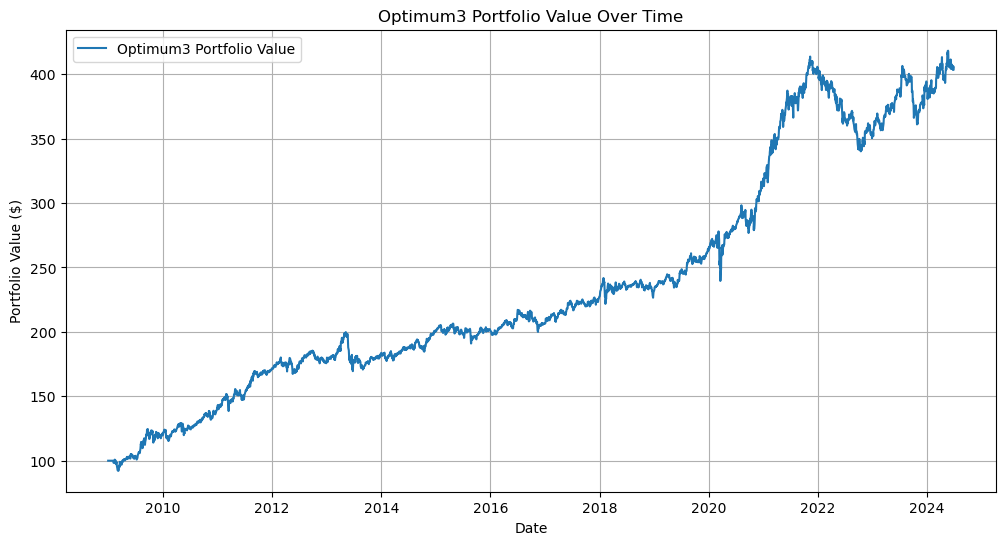

In [36]:
# Define the tickers for the strategy
tickers = ['SPY', 'QQQ', 'VNQ', 'REM', 'IEF', 'TLT', 'TIP', 'VGK', 'EWJ', 'SCZ', 'EEM', 'RWX', 'BWX', 'DBC', 'GLD', 'BIL']

# Download the data
start_date = '2008-01-01'
data = yf.download(tickers, start=start_date)['Adj Close']

# Calculate 6-month returns
monthly_data = data.resample('M').last()
six_month_returns = (monthly_data / monthly_data.shift(6) - 1).dropna()

# Function to calculate average correlation of a portfolio
def average_correlation(portfolio, data):
    return data[list(portfolio)].pct_change().corr().mean().mean()

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=six_month_returns.index, columns=tickers).fillna(0)

# Perform the Optimum3 strategy
for date in six_month_returns.index[6:]:
    # Calculate the 6-month returns for the assets
    asset_returns = six_month_returns.loc[date]
    
    # Select the top half with the highest 6-month returns
    top_half = asset_returns.nlargest(len(asset_returns) // 2).index.tolist()
    
    # Calculate correlations and select the 3 assets with the lowest average correlation
    best_portfolio = None
    best_correlation = float('inf')
    
    for portfolio in combinations(top_half, 3):
        corr = average_correlation(portfolio, data.loc[:date])
        if corr < best_correlation:
            best_correlation = corr
            best_portfolio = portfolio
    
    # Allocate 1/3 of the portfolio to each of the three selected assets
    if best_portfolio:
        for asset in best_portfolio:
            allocations.loc[date, asset] = 1 / 3

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

# Calculate portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='Optimum3 Portfolio Value')
plt.title('Optimum3 Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


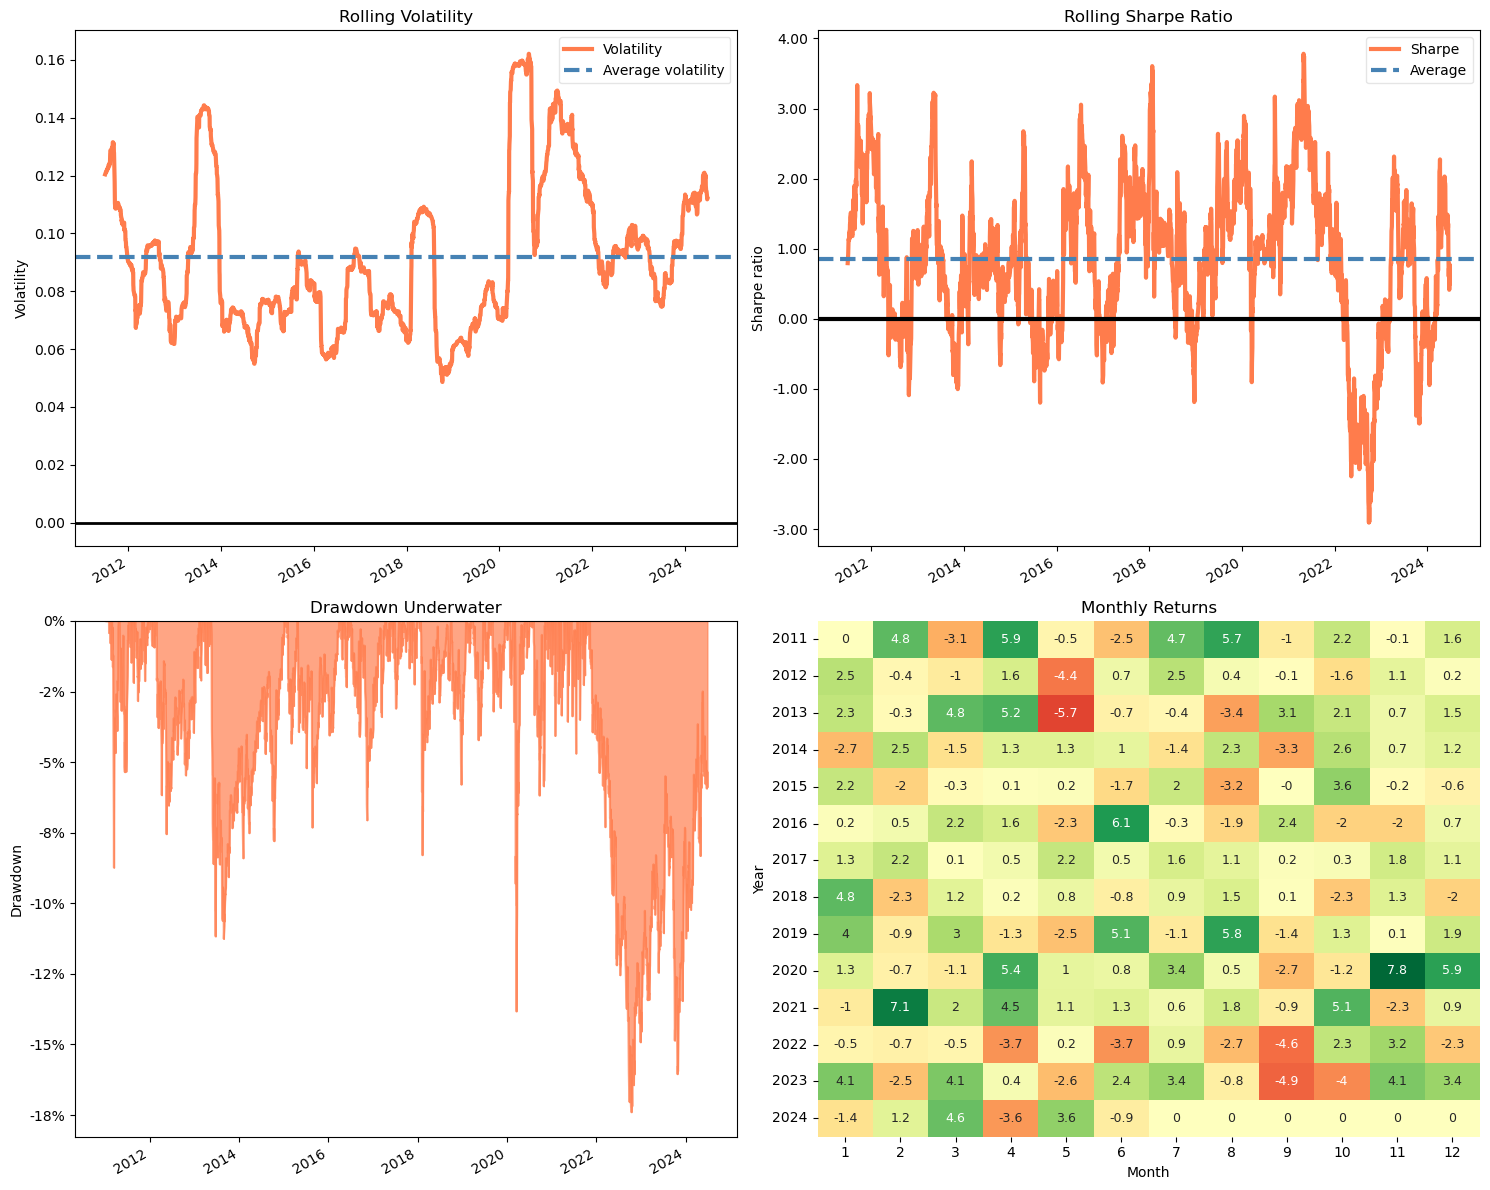

Annual return          0.077880
Cumulative returns     1.744147
Annual volatility      0.096058
Sharpe ratio           0.828952
Calmar ratio           0.447662
Stability              0.939804
Max drawdown          -0.173970
Omega ratio            1.157836
Sortino ratio          1.160328
Skew                  -0.479293
Kurtosis               4.444397
Tail ratio             0.990659
Daily value at risk   -0.011786
dtype: float64


/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [25]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

In [ ]:
#Bond canary risk off

[*********************100%%**********************]  16 of 16 completed


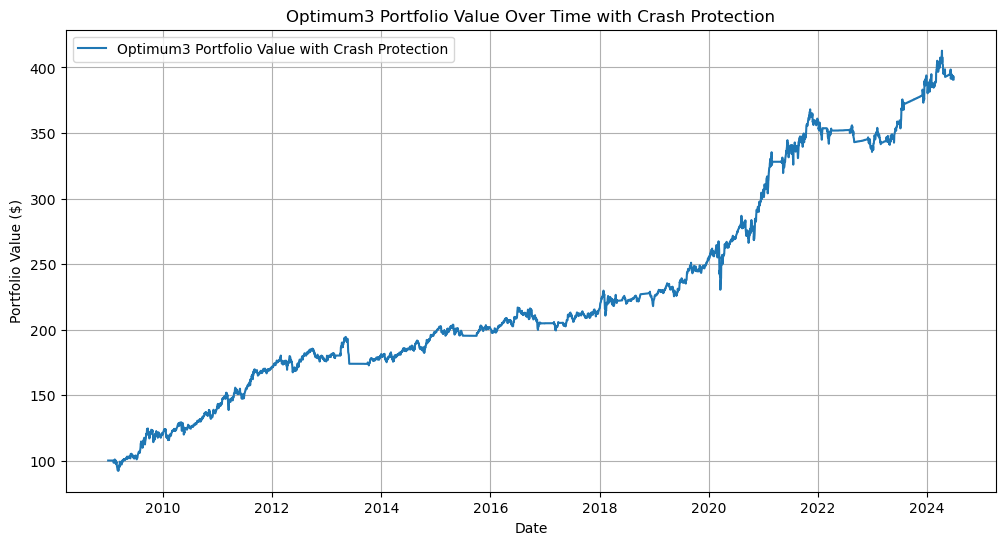

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Define the tickers for the strategy
tickers = ['SPY', 'QQQ', 'VNQ', 'REM', 'IEF', 'TLT', 'TIP', 'VGK', 'EWJ', 'SCZ', 'EEM', 'RWX', 'BWX', 'DBC', 'GLD', 'BIL']
bonds = ['IEF', 'TLT', 'TIP', 'BWX']
safe_asset = 'BIL'

# Download the data
start_date = '2008-01-01'
data = yf.download(tickers, start=start_date)['Adj Close']

# Calculate 6-month returns
monthly_data = data.resample('M').last()
six_month_returns = (monthly_data / monthly_data.shift(6) - 1).dropna()

# Function to calculate average correlation of a portfolio
def average_correlation(portfolio, data):
    return data[list(portfolio)].pct_change().corr().mean().mean()

# Function to calculate momentum score
def calculate_momentum_score(prices):
    p0 = prices.iloc[-1]
    p1 = prices.iloc[-2]
    p3 = prices.iloc[-4]
    p6 = prices.iloc[-7]
    momentum_score = (p0/p1 + p0/p3 + p0/p6)/3 - 1
    return momentum_score

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=six_month_returns.index, columns=tickers).fillna(0)

# Perform the Optimum3 strategy with crash protection
for date in six_month_returns.index[6:]:
    # Calculate the 6-month returns for the assets
    asset_returns = six_month_returns.loc[date]
    
    # Select the top half with the highest 6-month returns
    top_half = asset_returns.nlargest(len(asset_returns) // 2).index.tolist()
    
    # Calculate correlations and select the 3 assets with the lowest average correlation
    best_portfolio = None
    best_correlation = float('inf')
    
    for portfolio in combinations(top_half, 3):
        corr = average_correlation(portfolio, data.loc[:date])
        if corr < best_correlation:
            best_correlation = corr
            best_portfolio = portfolio
    
    # Allocate 1/3 of the portfolio to each of the three selected assets
    if best_portfolio:
        for asset in best_portfolio:
            allocations.loc[date, asset] = 1 / 3
    
    # Crash protection mechanism
    # If all bonds are underperforming (negative momentum), allocate to BIL
    bond_momentum_scores = {bond: calculate_momentum_score(monthly_data.loc[:date, bond]) for bond in bonds}
    if all(score < 0 for score in bond_momentum_scores.values()):
        allocations.loc[date] = 0  # Reset allocations
        allocations.loc[date, safe_asset] = 1.0

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

# Calculate portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='Optimum3 Portfolio Value with Crash Protection')
plt.title('Optimum3 Portfolio Value Over Time with Crash Protection')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


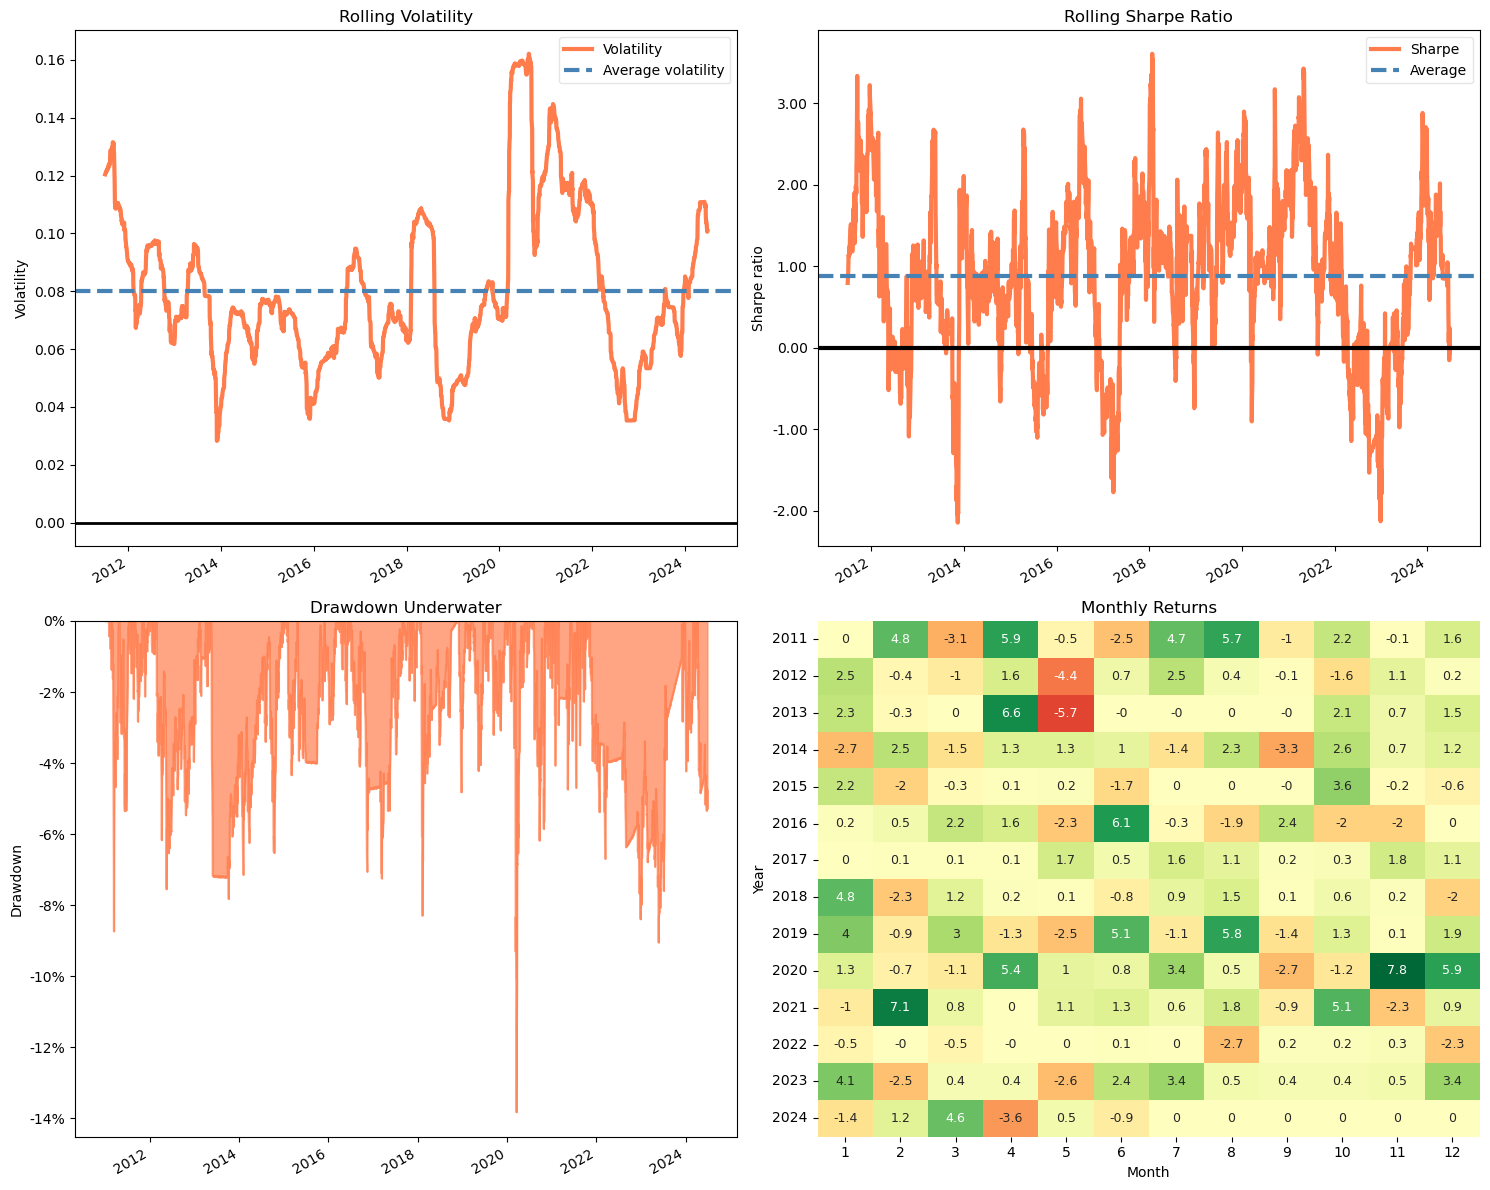

Annual return          0.076526
Cumulative returns     1.698123
Annual volatility      0.085524
Sharpe ratio           0.905153
Calmar ratio           0.553449
Stability              0.941667
Max drawdown          -0.138271
Omega ratio            1.194199
Sortino ratio          1.274364
Skew                  -0.524404
Kurtosis               6.637672
Tail ratio             0.997697
Daily value at risk   -0.010468
dtype: float64


/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [27]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

In [ ]:
# Volatility targeting and bond canary risk-off

[*********************100%%**********************]  16 of 16 completed


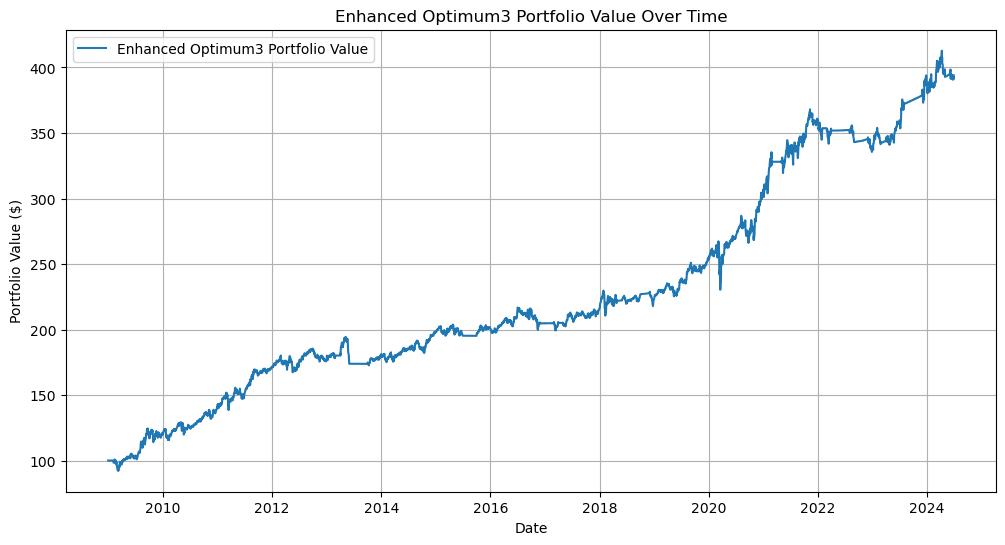

In [49]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Define the tickers for the strategy
tickers = ['SPY', 'QQQ', 'VNQ', 'REM', 'IEF', 'TLT', 'TIP', 'VGK', 'EWJ', 'SCZ', 'EEM', 'RWX', 'BWX', 'DBC', 'GLD', 'BIL']
bonds = ['IEF', 'TLT', 'TIP', 'BWX']
safe_asset = 'BIL'

# Download the data
start_date = '2008-01-01'
data = yf.download(tickers, start=start_date)['Adj Close']

# Calculate 6-month returns
monthly_data = data.resample('M').last()
six_month_returns = (monthly_data / monthly_data.shift(6) - 1).dropna()

# Function to calculate average correlation of a portfolio
def average_correlation(portfolio, data):
    return data[list(portfolio)].pct_change().corr().mean().mean()

# Function to calculate momentum score
def calculate_momentum_score(prices):
    p0 = prices.iloc[-1]
    p1 = prices.iloc[-2]
    p3 = prices.iloc[-4]
    p6 = prices.iloc[-7]
    momentum_score = (p0/p1 + p0/p3 + p0/p6)/3 - 1
    return momentum_score

# Function to calculate volatility
def calculate_volatility(returns, window=21):
    return returns.rolling(window).std().iloc[-1]

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=six_month_returns.index, columns=tickers).fillna(0)

# Perform the Optimum3 strategy with crash protection and volatility targeting
for date in six_month_returns.index[6:]:
    # Calculate the 6-month returns for the assets
    asset_returns = six_month_returns.loc[date]
    
    # Select the top half with the highest 6-month returns
    top_half = asset_returns.nlargest(len(asset_returns) // 2).index.tolist()
    
    # Calculate correlations and select the 3 assets with the lowest average correlation
    best_portfolio = None
    best_correlation = float('inf')
    
    for portfolio in combinations(top_half, 3):
        corr = average_correlation(portfolio, data.loc[:date])
        if corr < best_correlation:
            best_correlation = corr
            best_portfolio = portfolio
    
    # Allocate 1/3 of the portfolio to each of the three selected assets
    if best_portfolio:
        for asset in best_portfolio:
            allocations.loc[date, asset] = 1 / 3
    
    # Crash protection mechanism
    # If all bonds are underperforming (negative momentum), allocate to BIL
    bond_momentum_scores = {bond: calculate_momentum_score(monthly_data.loc[:date, bond]) for bond in bonds}
    if all(score < 0 for score in bond_momentum_scores.values()):
        allocations.loc[date] = 0  # Reset allocations
        allocations.loc[date, safe_asset] = 1.0
    
    # Volatility targeting
    portfolio_volatility = calculate_volatility(data.pct_change().loc[:date, best_portfolio].mean(axis=1))
    target_volatility = 0.10  # Target volatility of 10%
    
    if portfolio_volatility > target_volatility:
        allocations.loc[date] *= target_volatility / portfolio_volatility

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

# Calculate portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='Enhanced Optimum3 Portfolio Value')
plt.title('Enhanced Optimum3 Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


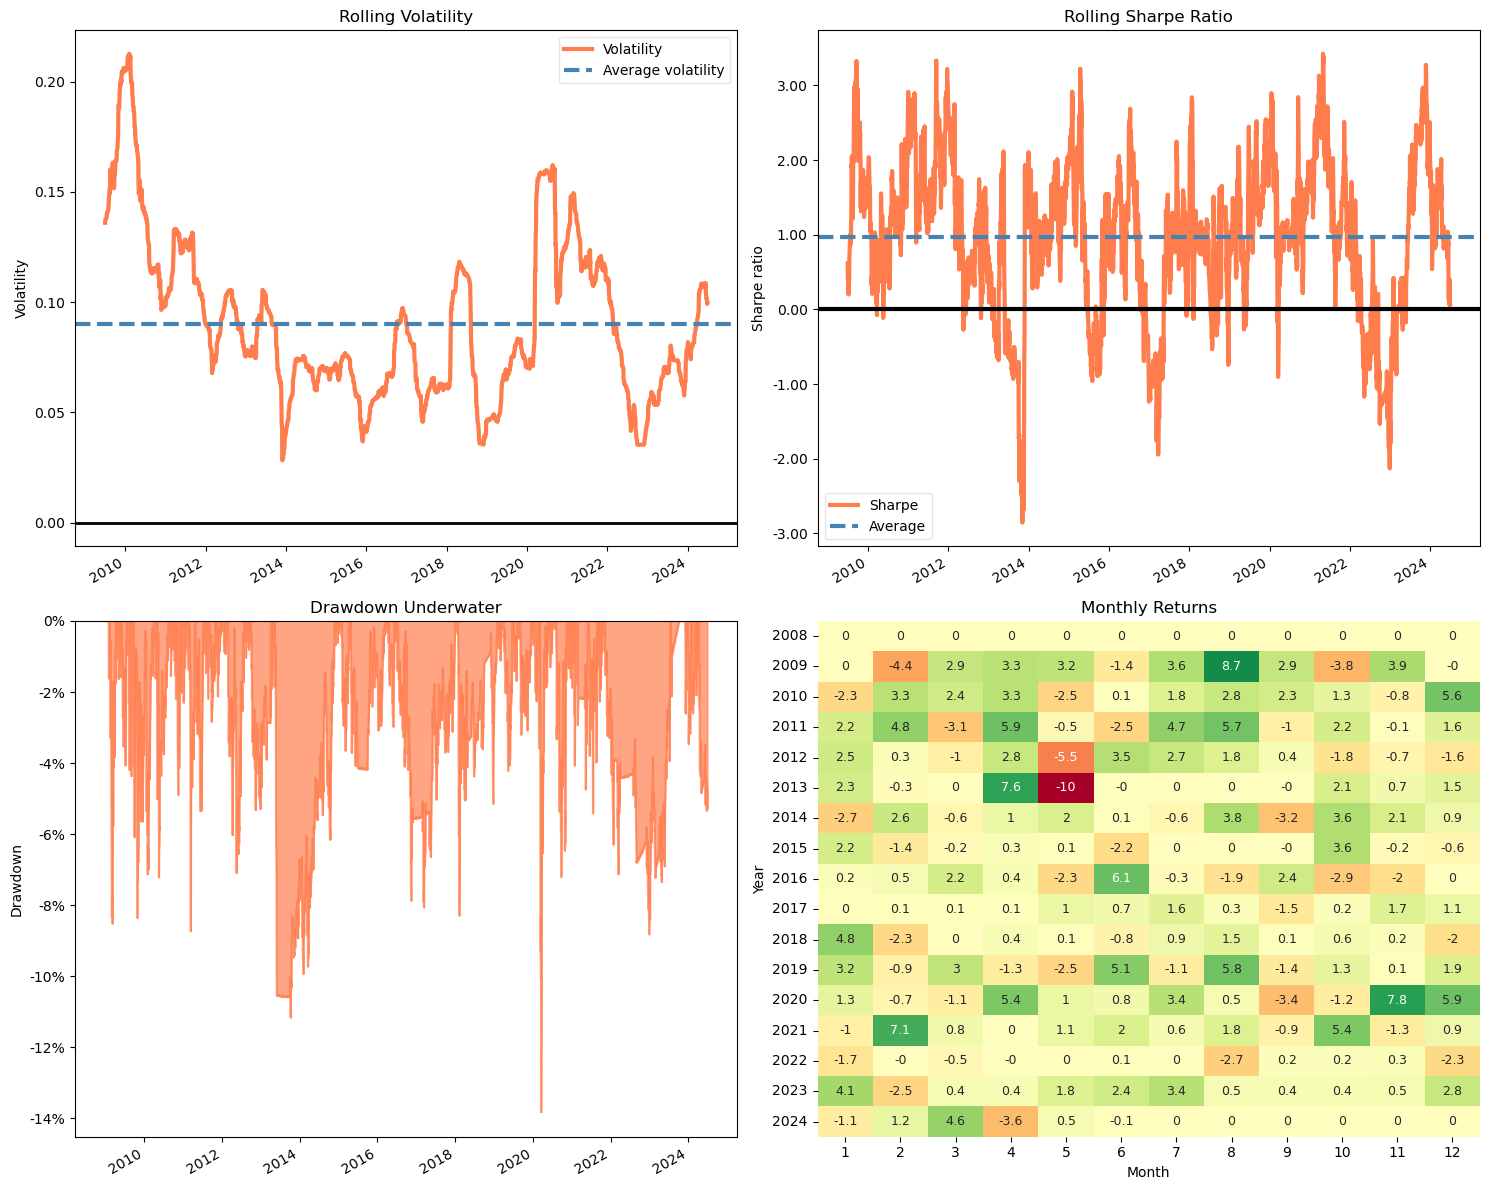

Annual return          0.092702
Cumulative returns     2.940545
Annual volatility      0.097855
Sharpe ratio           0.955100
Calmar ratio           0.670437
Stability              0.944997
Max drawdown          -0.138271
Omega ratio            1.203075
Sortino ratio          1.362235
Skew                  -0.341751
Kurtosis               5.573926
Tail ratio             1.055883
Daily value at risk   -0.011958
dtype: float64


/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [50]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()

perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

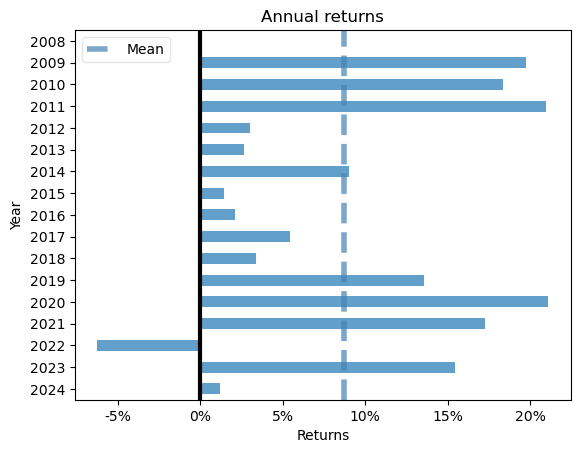

In [54]:
pf.plot_annual_returns(strategy_returns)

In [53]:
daily_allocations

,SPY,QQQ,VNQ,REM,IEF,TLT,TIP,VGK,EWJ,SCZ,EEM,RWX,BWX,DBC,GLD,BIL
Date,,,,,,,,,,,,,,,,
2008-01-02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2008-01-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2008-01-04,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2008-01-07,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2008-01-08,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
2024-06-24,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
2024-06-25,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
